In [44]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
! pip install textblob


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [46]:
from textblob import TextBlob

In [47]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
# Replace with your actual filename after re-upload
df = pd.read_csv(r"C:\Users\hp\Downloads\blogs.csv.crdownload", on_bad_lines='skip')
print(df.head())
print(df.info())
print(df['Labels'].value_counts())

                                                Data       Labels
0  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  alt.atheism
1  Newsgroups: alt.atheism\nPath: cantaloupe.srv....  alt.atheism
2  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...  alt.atheism
3  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  alt.atheism
4  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...  alt.atheism
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58694 entries, 0 to 58693
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    58694 non-null  object
 1   Labels  11200 non-null  object
dtypes: object(2)
memory usage: 917.2+ KB
None
Labels
                                               93
and                                            69
Inc.                                           57
but                                            41
the                                            27
                                               .

In [49]:
print(df.isnull().sum())

Data          0
Labels    47494
dtype: int64


In [50]:
df.shape

(58694, 2)

In [51]:
# Step 1: Convert 'Labels' to actual NaNs if they are strings like 'nan'
df['Labels'].replace(['nan', 'NaN', ''], np.nan, inplace=True)

# Step 2: Drop rows with missing labels
df = df.dropna(subset=['Labels']).reset_index(drop=True)

# Step 3: Confirm the cleanup worked
print("Remaining rows after dropping missing labels:", len(df))
print("Null counts:\n", df.isnull().sum())

Remaining rows after dropping missing labels: 11200
Null counts:
 Data      0
Labels    0
dtype: int64


C:\Users\hp\AppData\Local\Temp\ipykernel_13284\1087936008.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Labels'].replace(['nan', 'NaN', ''], np.nan, inplace=True)


In [52]:
# Define stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [53]:
# Clean text function with better error handling
def clean_text(text):
    try:
        text = str(text)  # Ensure it's a string
        text = text.lower()
       
        # Remove non-alphabetical characters
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]  # Stemming and removing stopwords
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error cleaning text: {e}")
        return ""

In [54]:
# Apply cleaning function
df['Cleaned_Data'] = df['Data'].astype(str).apply(clean_text)
df['Labels'] = df['Labels'].astype(str).str.replace(r'[^\w\s]', '', regex=True).str.strip()

# Remove rows where cleaning failed (empty string)
df = df[df['Cleaned_Data'].str.strip() != ''].reset_index(drop=True)

# Feature Extraction - Using a more optimized TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5, max_df=0.95)
X = vectorizer.fit_transform(df['Cleaned_Data'])
y = df['Labels']

In [55]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Naive Bayes Classifier
model = MultinomialNB(alpha=1.0)  # You can tune alpha parameter based on GridSearchCV
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='weighted', zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted', zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.022091974752028856
Precision: 0.007236275661725193
Recall: 0.022091974752028856
F1 Score: 0.008455703846357854

Classification Report:
                                                                          precision    recall  f1-score   support

                                                                              0.01      0.95      0.02        21
                    000 as my budget  Im looking for a sports or GT car       0.00      0.00      0.00         1
                                     000 per day  We are slowly gaining       0.00      0.00      0.00         1
                            002251waxeacadiauca JASON WALTER WORKS says       0.00      0.00      0.00         1
                                                   06 Apr 93 081041 PDT       0.00      0.00      0.00         1
                                                0X24 WPET1W747G4 AH7 UO       0.00      0.00      0.00         1
                                               0X372 165 DEH

In [56]:
# Sentiment Analysis - Improving the threshold for more meaningful classification
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.2:  # Adjusted threshold for a more distinct classification
        return 'Positive'
    elif polarity < -0.2:  # Adjusted threshold for a more distinct classification
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = df['Data'].astype(str).apply(get_sentiment)

Sentiment                          Negative   Neutral  Positive
                                   0.076336  0.778626  0.145038
0 2PXG                             0.000000  1.000000  0.000000
000                                0.000000  0.666667  0.333333
000 YEARS  FOLLOW THE KING OF ...  0.000000  1.000000  0.000000
000 and has 5 rinks  There         0.000000  1.000000  0.000000
...                                     ...       ...       ...
youre not affected at all          0.000000  1.000000  0.000000
youve also changed the terrain...  0.000000  1.000000  0.000000
youve been telling us that the     0.000000  1.000000  0.000000
zeven jaar na de oprichting va...  0.000000  1.000000  0.000000
zrepacholcccurtineduau Paul Re...  0.000000  1.000000  0.000000

[9664 rows x 3 columns]


c:\Users\hp\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


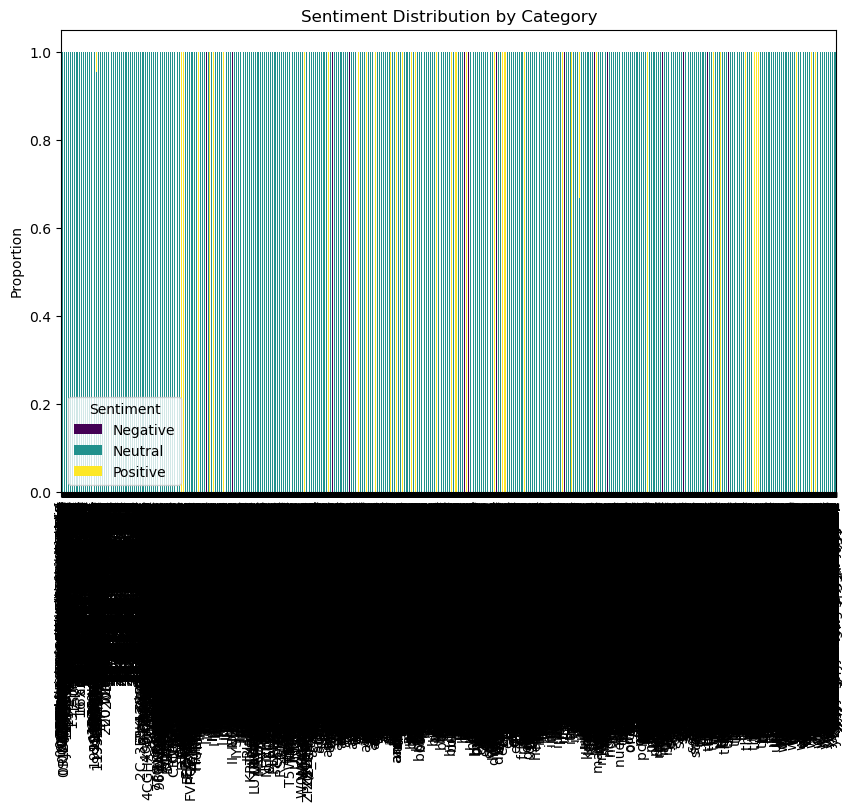

In [57]:
# Sentiment Distribution by Category
sentiment_summary = df.groupby('Labels')['Sentiment'].value_counts(normalize=True).unstack().fillna(0)
sentiment_summary.index = [label[:30] + '...' if len(label) > 30 else label for label in sentiment_summary.index]
print(sentiment_summary)

# Plot the sentiment distribution by category
sentiment_summary.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title("Sentiment Distribution by Category")
plt.ylabel("Proportion")
plt.show()